# Homework 11.3: Quantum Phase Estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

In [1]:
### START DO NOT CHANGE ###
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, transpile, assemble#, IBMQ
from qiskit_aer import Aer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import os.path
import matplotlib.pyplot as plt
import math

token_file = 'token.txt'
assert os.path.exists(token_file)

# Common variables
nqubits = 3
shots = 2048
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits 
    # NOTE: we reduced n by one earlier in the function
    qft_rotations(circuit, n)

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit.decompose() # .decompose() allows us to see the individual gates

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

def load_IBMQ():
    QiskitRuntimeService.delete_account()
    with open('token.txt') as f:
        token = f.read()
        QiskitRuntimeService.save_account(channel='ibm_quantum',token=token,set_as_default=True,overwrite=True)
    service = QiskitRuntimeService()
    return service

def simulate(circuit):
    qc = circuit.copy()
    job = sim.run(qc)
    return job.result().get_counts()

def run_job(circuit):
    qc = circuit.copy()
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    return job.result().get_counts()

service = load_IBMQ()
backend = service.least_busy(operational=True,simulator=False,min_num_qubits=nqubits)
sim = Aer.get_backend("aer_simulator")

### END DO NOT CHANGE ###

As an example, we will run QPE on the $T$-gate to estimate its phase. The $T$-gate is given by

\begin{align}
T = \begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\end{align}

Running QPE on $T$ will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$

# The Problem <a id='the_problem'></a>

In this notebook, you will estimate the phase of the rotation gate $$S = \begin{bmatrix} 1 & 0 \\ 0 & e^{\frac{8 \pi i}{5}} \end{bmatrix}$$ using 3 and 5 counting qubits.

### (a) What are the eigenstates and eigenvalues of this operator? What is the phase $\theta$?

$$ S|1\rangle = e^{2i\pi\theta}|1\rangle $$


$$\theta = \frac{4}{5}$$

Moving forward, we let $| \psi \rangle$ be the eigenstate of $S$ that is not equal to $| 0 \rangle$.

# Three Counting Qubits

We will first estimate the phase $\theta$ using 3 qubits. 

### (b) How many qubits total do we need for this process?

Three counting qubits and one qubits in the state $| \psi \rangle$. FOUR TOTAL

### (c)(i) State preparation: We provide a circuit that has the amount of qubits from answer (b). Your job is to prepare the eigenstate $| \psi \rangle$ on the last qubit.

In [2]:
### BEGIN DO NOT CHANGE ###
qpe = QuantumCircuit(4,3)
### END DO NOT CHANGE ###

### BEGIN YOUR CODE ###

qpe.x(3)

### BEGIN YOUR CODE ###

### (c)(ii) Apply $H$-gates to all the counting qubits

In [3]:
### BEGIN YOUR CODE ###

for qubit in range(3):
    qpe.h(qubit)

### BEGIN YOUR CODE ###

### (d) Now we need to add the controlled U operations. Most of the logic is in the provided method `controlled_U`, your task is to call this function with the correct angle.

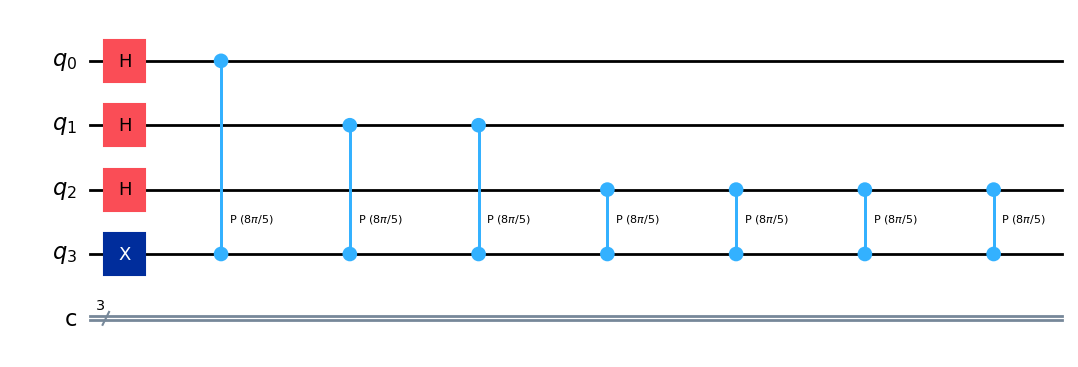

In [4]:
### BEGIN DO NOT CHANGE ###
def controlled_U(circuit, angle, num_counting_qubits):
    repetitions = 1
    for counting_qubit in range(num_counting_qubits):
        for i in range(repetitions):
            circuit.cp(angle, counting_qubit, num_counting_qubits);
        repetitions *= 2
    
    return circuit
### END DO NOT CHANGE ###

### BEGIN YOUR CODE ###

controlled_U(qpe, (8*pi/5), 3)

### END YOUR CODE ###

qpe.draw('mpl')

### (e) Lastly, add the inverse QFT to the appropriate qubits using the `qft_dagger` method

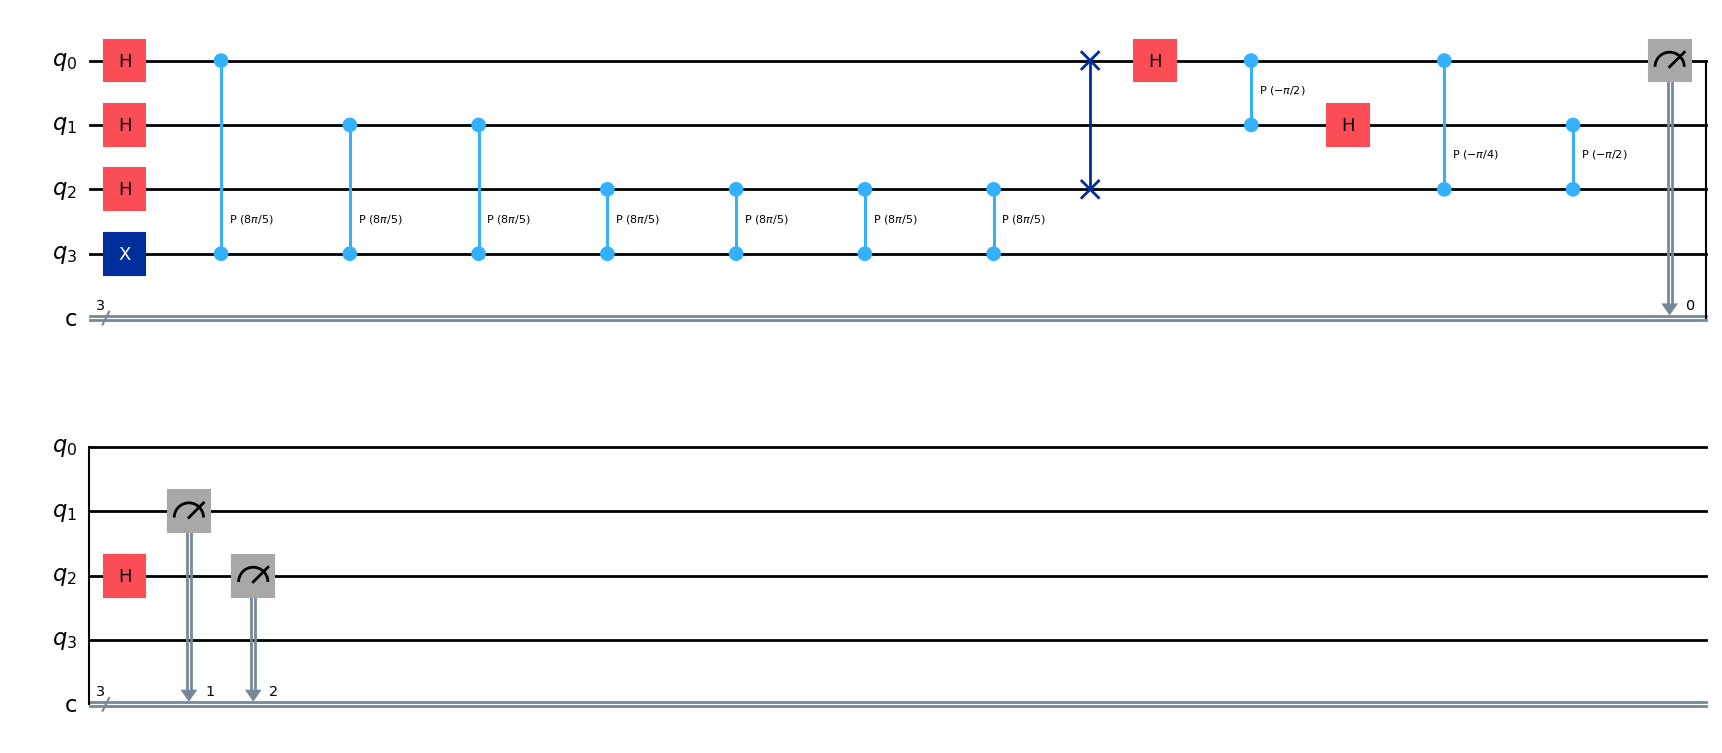

In [5]:
### BEGIN YOUR CODE ###

qft_dagger(qpe, 3)

### BEGIN YOUR CODE ###


### BEGIN DO NO CHANGE ###
for n in range(3):
    qpe.measure(n,n)
qpe.draw('mpl')
### END DO NO CHANGE ###

In [6]:
### BEGIN DO NO CHANGE ###
counts_simulated = simulate(qpe)
counts_real = run_job(qpe)
### END DO NO CHANGE ###

/tmp/ipykernel_125/3538579329.py:79: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_qc, shots=shots)


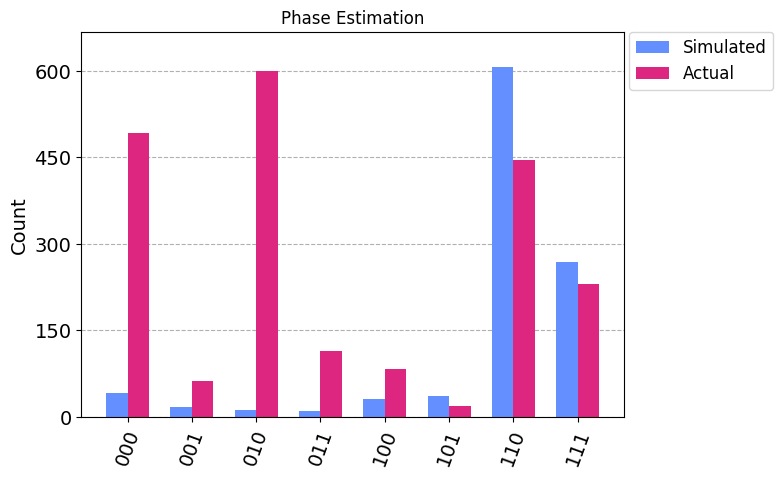

In [7]:
### BEGIN DO NO CHANGE ###
legend = ['Simulated', 'Actual']
plot_histogram([counts_simulated, counts_real], legend=legend, bar_labels=False, title='Phase Estimation')
### END DO NO CHANGE ###

If $x_1x_2x_3$ is a bitstring that occurs with high probability and $x$ is its decimal representation, then we expect that $\theta \approx x / 2^3$. (The 3 corresponds to the 3 counting qubits) 

### (f) Interpret your results: which bitstring(s) have the highest probability? How does this correspond to the real $\theta$?

The bit strings with the highest probability are 110 and 111. This makes sense as 110 translates to the decimal 6, and $\frac{6}{2^n} = \frac{6}{8}$ is close to the real $\theta = \frac{4}{5}$. Similarly, 111 translates to the decimal 6, and $\frac{7}{2^n} = \frac{7}{8}$ is slightly less close to the real $\theta = \frac{4}{5}$.

We will now repeat steps (b)-(f) from above using five counting qubits instead of three.

## Five Counting Qubits

To get more precision we simply add more counting qubits. We are going to add two more counting qubits for 5 total.

### (g) How many qubits total do we need for this process?

Five counting qubits and one qubits in the state $| \psi \rangle$. SIX TOTAL

### (h)(i) State preparation: We construct a circuit that has the amount of qubits from answer (g). Your job is to prepare the eigenstate $| \psi \rangle$ on the last qubit.

In [8]:
### BEGIN DO NOT CHANGE ###
qpe5 = QuantumCircuit(6,5)
### END DO NOT CHANGE ###

### BEGIN YOUR CODE ###

qpe5.x(5)

### END YOUR CODE ###

### (h)(ii) Apply $H$-gates to all the counting qubits

In [9]:
### BEGIN YOUR CODE ###

for qubit in range(5):
    qpe5.h(qubit)

### END YOUR CODE ###

### (i) Add the controlled-U gates

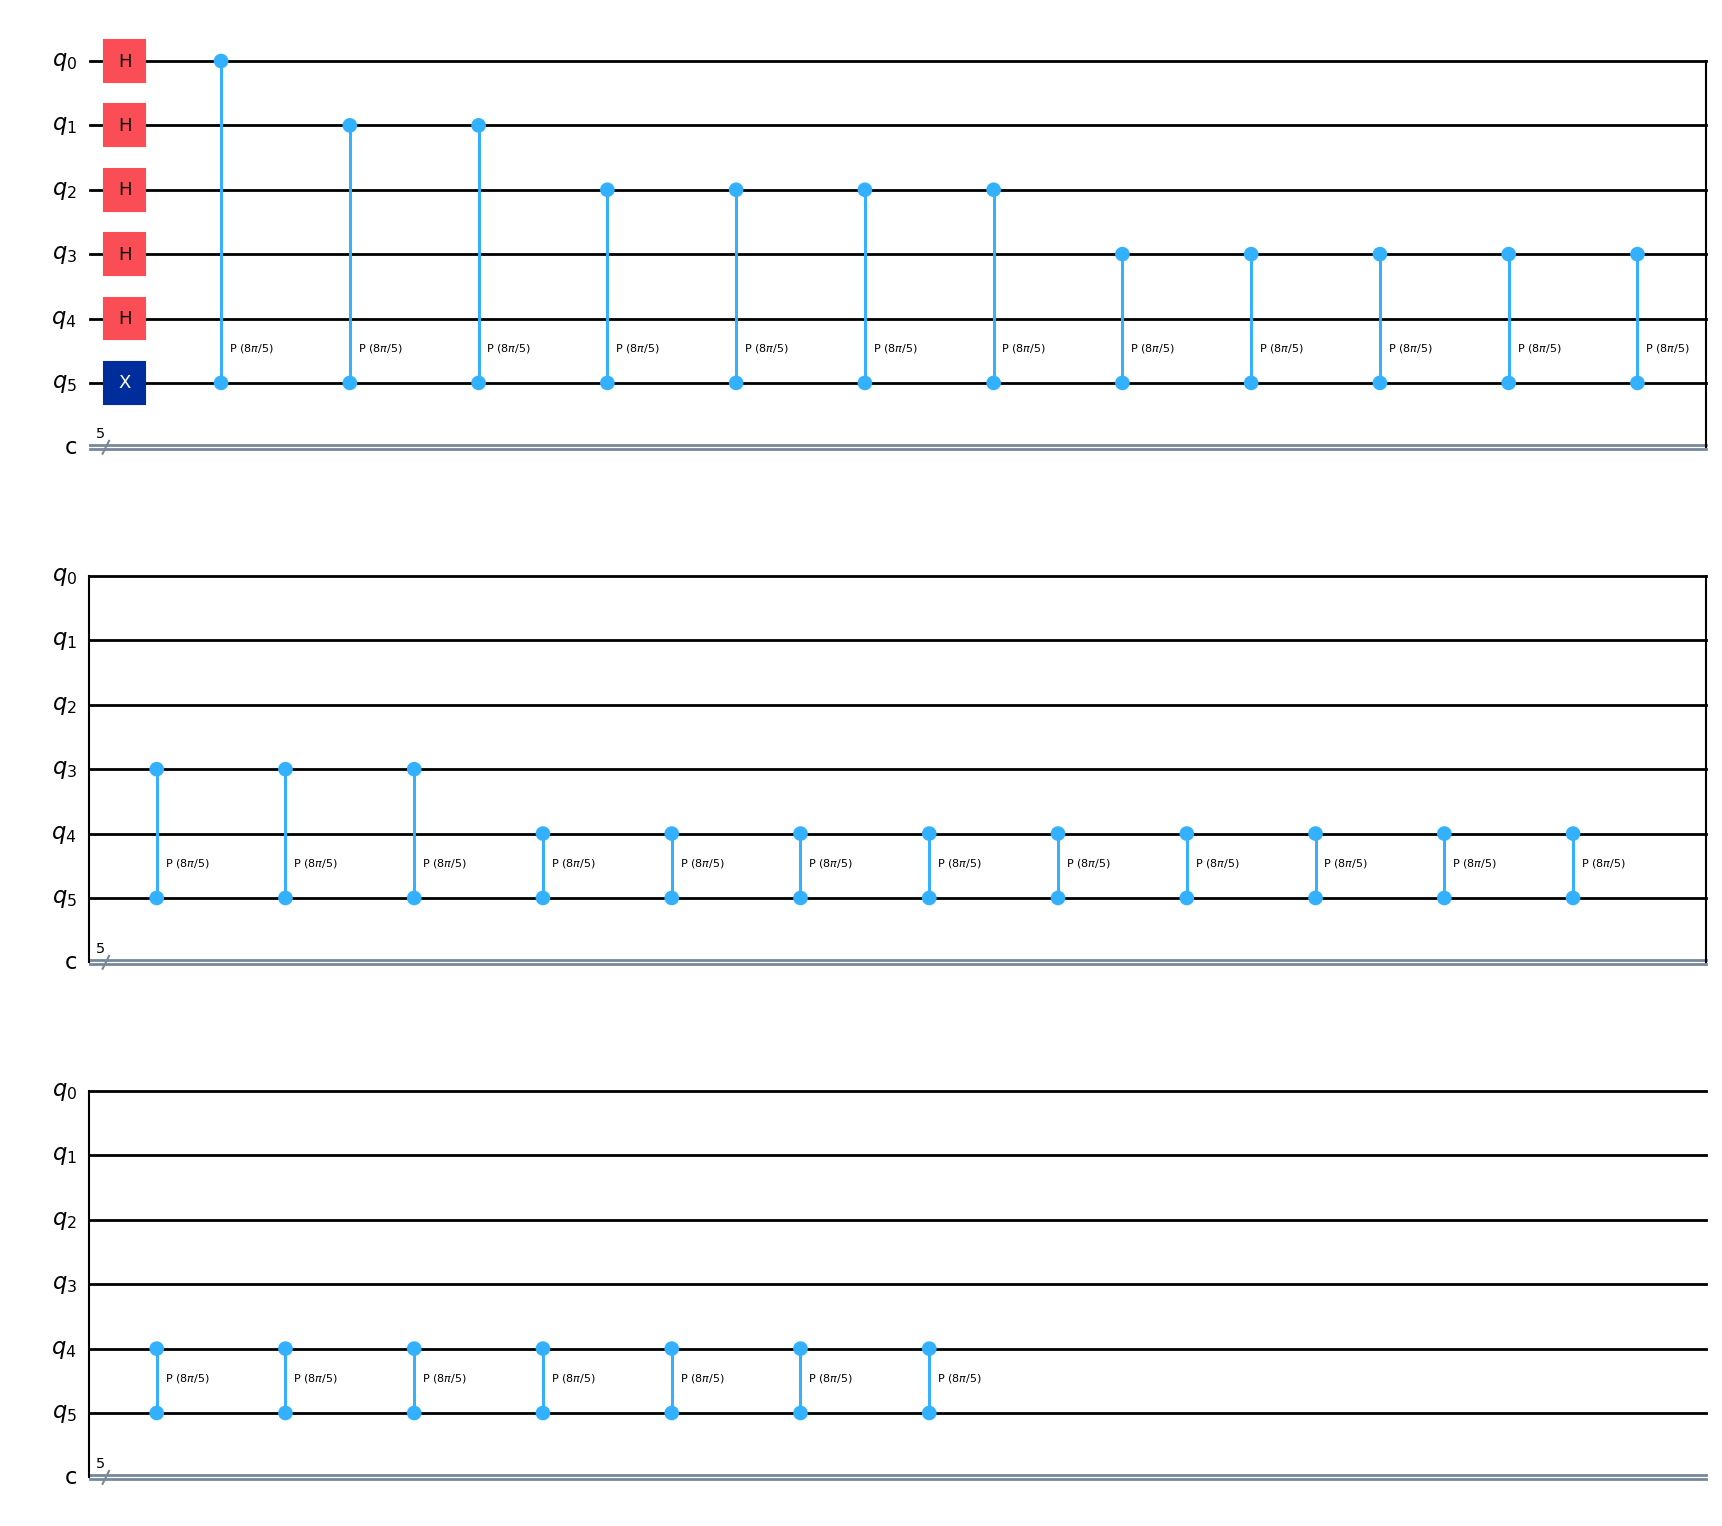

In [10]:
### BEGIN YOUR CODE ###

controlled_U(qpe5, (8*pi/5), 5)

### END YOUR CODE ###

qpe5.draw('mpl')

### (j) Lastly, add the inverse QFT to the appropriate qubits using the `qft_dagger` method

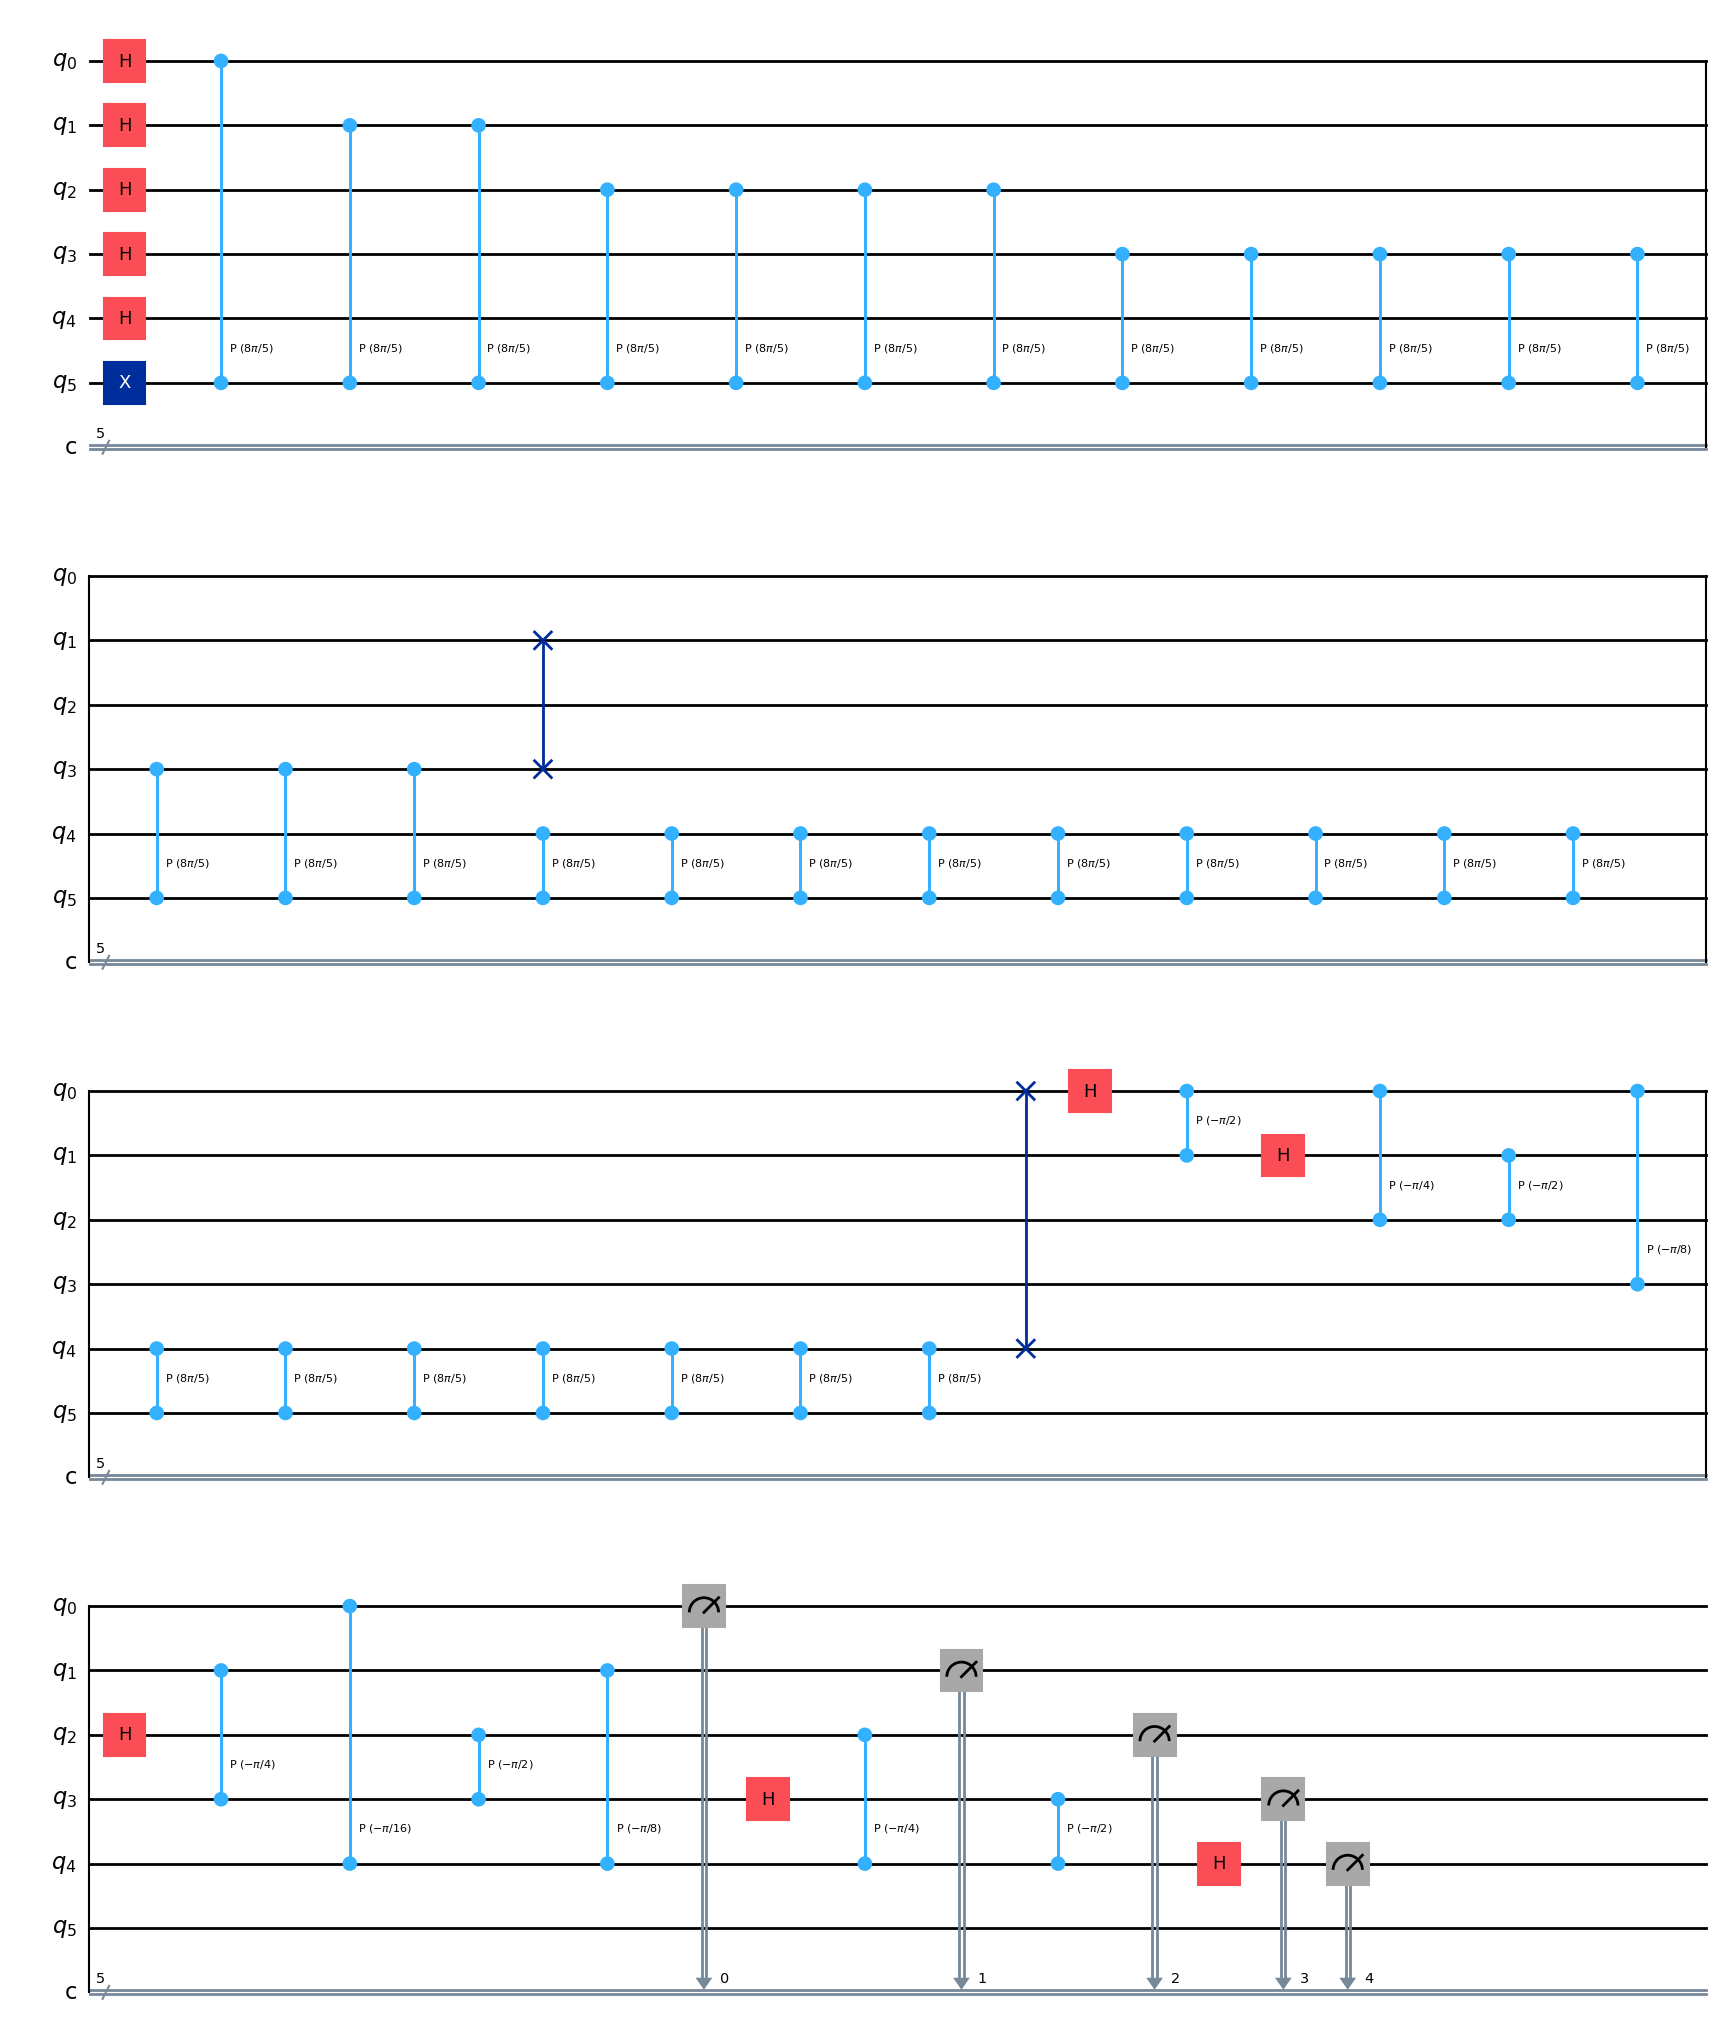

In [11]:
### BEGIN YOUR CODE ###

qft_dagger(qpe5, 5)

### END YOUR CODE ###

### BEGIN DO NO TOUCH ###
for n in range(5):
    qpe5.measure(n,n)
qpe5.draw('mpl')
### END DO NO TOUCH ###

In [12]:
### BEGIN YOUR CODE ###
counts_simulated = simulate(qpe5)
### END YOUR CODE ###

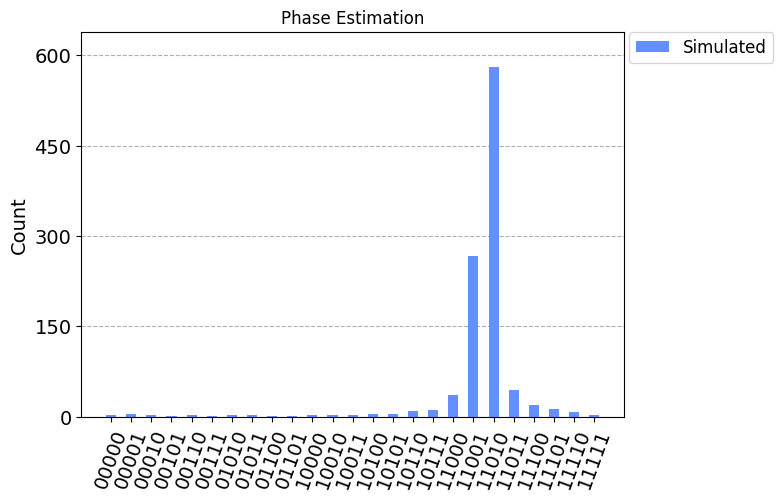

In [13]:
### BEGIN YOUR CODE ###
legend = ['Simulated']
plot_histogram([counts_simulated], legend=legend, bar_labels=False, title='Phase Estimation')
### END YOUR CODE ###

### (k) Once again, interpret your results. How do these approximations compare to those in the 3-qubit case?

We can tell that using 5 counting qubits is much more acurate, as the bit strings with the highest probability are 11010 and 11001. This makes sense as 11010 translates to the decimal 26, and $\frac{26}{2^n} = \frac{26}{32}$ is closer to the real $\theta = \frac{4}{5}$ compared to the previous fraction of $\frac{6}{8}$. Similarly, 11001 translates to the decimal 25, and $\frac{25}{2^n} = \frac{25}{32}$ is slightly less close, but still closer to the real $\theta = \frac{4}{5}$ than the previous $\frac{7}{8}$.

## References <a id='references'></a>

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 